In [2]:
pip install torchinfo medmnist torchmetrics torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.5 MB/s eta 0:00:00


In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import medmnist
import torch.nn.functional as F
from medmnist import INFO, Evaluator
import torch.optim as optim
from torchinfo import summary
from collections import Counter
import torch.nn.init as init
import torchmetrics
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score
import time
# MedMNIST dataset settings
data_flag = 'octmnist'
# data_flag = 'breastmnist'
download = True


BATCH_SIZE = 128


info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
class_labels = {int(k): v for k, v in info['label'].items()}
print(class_labels)
DataClass = getattr(medmnist, info['python_class'])
print(info)

{0: 'choroidal neovascularization', 1: 'diabetic macular edema', 2: 'drusen', 3: 'normal'}
{'python_class': 'OCTMNIST', 'description': 'The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.', 'url': 'https://zenodo.org/records/10519652/files/octmnist.npz?download=1', 'MD5': 'c68d92d5b585d8d81f7112f81e2d0842', 'url_64': 'https://zenodo.org/records/10519652/files/octmnist_64.npz?download=1', 'MD5_64': 'e229e9440236b774d9f0dfef9d07bdaf', 'url_128': 'https://zenodo.org/records/10519652/files/octmnist_128.npz?download=1', 'MD5_128': '0a97e76651ace45c5d943ee3f65b

Preprocessing of dataset using normalisaton to keep values between -1 and 1

Also splitting the data into Testing,Val and Training Data

In [3]:
data_transform = transforms.Compose([
    #transforms.RandomRotation(15),  # Rotate images randomly by ±15°
    #transforms.RandomHorizontalFlip(),  # Flip images horizontally
    #transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Random translations
    #transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),  # Random crop & resize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

data_transform_training = transforms.Compose([
  #  transforms.RandomRotation(15),  # Rotate images randomly by ±15°
  #  transforms.RandomHorizontalFlip(),  # Flip images horizontally
 #   transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Random translations
 #   transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),  # Random crop & resize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])



In [4]:
# load the data
train_dataset = DataClass(split='train', transform=data_transform_training, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz


### **Main Data Statistics**

In [ ]:
print("Training Data Statistics")
print(train_dataset)
num_samples = len(train_dataset)
image_shape = train_dataset[0][0].shape  # Get shape of one image
labels = [train_dataset[i][1] for i in range(num_samples)]  # Extract all labels
unique_classes, class_counts = np.unique(labels, return_counts=True)  # Count occurrences per class
class_distribution = {class_labels[k]: v for k, v in zip(unique_classes, class_counts)}

print(f"Total Images: {num_samples}")
print(f"Image Shape: {image_shape}")
print(f"Number of Classes: {len(unique_classes)}")
print(f"Class Distribution: {class_distribution}")

print("===================")
print("===================")

print("Val Data Statistics")
print(val_dataset)
num_samples = len(val_dataset)
image_shape =val_dataset[0][0].shape  # Get shape of one image
labels = [val_dataset[i][1] for i in range(num_samples)]  # Extract all labels
unique_classes, class_counts = np.unique(labels, return_counts=True)  # Count occurrences per class
class_distribution = {class_labels[k]: v for k, v in zip(unique_classes, class_counts)}

print(f"Total Images: {num_samples}")
print(f"Image Shape: {image_shape}")
print(f"Number of Classes: {len(unique_classes)}")
print(f"Class Distribution: {class_distribution}")

print("===================")
print("===================")

print("Testing Data Statistics")
print(test_dataset)

num_samples = len(test_dataset)
image_shape = test_dataset[0][0].shape  # Get shape of one image
labels = [test_dataset[i][1] for i in range(num_samples)]  # Extract all labels
unique_classes, class_counts = np.unique(labels, return_counts=True)  # Count occurrences per class
class_distribution = {class_labels[k]: v for k, v in zip(unique_classes, class_counts)}

print(f"Total Images: {num_samples}")
print(f"Image Shape: {image_shape}")
print(f"Number of Classes: {len(unique_classes)}")
print(f"Class Distribution: {class_distribution}")

Training Data Statistics
Dataset OCTMNIST of size 28 (octmnist)
    Number of datapoints: 97477
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'choroidal neovascularization', '1': 'diabetic macular edema', '2': 'drusen', '3': 'normal'}
    Number of samples: {'train': 97477, 'val': 10832, 'test': 1000}
    Description: The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Total Images: 97477
Image Shape: torch.Size([1, 28, 28])
Number of Classes: 4
Class

Neural Network

In [5]:

class DeeperSeqCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(DeeperSeqCNN, self).__init__()


        self.model = nn.Sequential(
            # 1st Convolution Block
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
           # nn.AdaptiveAvgPool2d(1),

            # 2nd Convolution Block
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.AdaptiveAvgPool2d(1),
            # 3rd Convolution Block (ADDED)
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.AdaptiveAvgPool2d(1),
            # 4th Convolution Block (ADDED)
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.AdaptiveAvgPool2d(1),


            # Flatten before fully connected
            nn.Flatten(),

            # Dropout (optional)
            nn.Dropout(0.5),

            # Fully Connected layer
            # After 4 blocks with input 28x28, feature map size is 1x1
            nn.Linear(512 * 1 * 1, num_classes))

    def forward(self, x):
        return self.model(x)


# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def initialize_weights_kaiming(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_uniform_(m.weight, nonlinearity='leaky_relu')  # He Uniform
        if m.bias is not None:
            init.zeros_(m.bias)




cuda


In [ ]:
model = DeeperSeqCNN(num_classes=4).to(device)
# Apply to model
model.apply(initialize_weights_kaiming)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0006, weight_decay=5e-4)
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
DeeperSeqCNN                             [1, 4]                    --
├─Sequential: 1-1                        [1, 4]                    --
│    └─Conv2d: 2-1                       [1, 64, 28, 28]           640
│    └─BatchNorm2d: 2-2                  [1, 64, 28, 28]           128
│    └─LeakyReLU: 2-3                    [1, 64, 28, 28]           --
│    └─MaxPool2d: 2-4                    [1, 64, 14, 14]           --
│    └─Conv2d: 2-5                       [1, 128, 14, 14]          73,856
│    └─BatchNorm2d: 2-6                  [1, 128, 14, 14]          256
│    └─LeakyReLU: 2-7                    [1, 128, 14, 14]          --
│    └─MaxPool2d: 2-8                    [1, 128, 7, 7]            --
│    └─Conv2d: 2-9                       [1, 256, 7, 7]            295,168
│    └─BatchNorm2d: 2-10                 [1, 256, 7, 7]            512
│    └─LeakyReLU: 2-11                   [1, 256, 7, 7]            --
│ 

Training model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score

# Initialize metric trackers
num_classes = 4  # Adjust based on the number of classes in your dataset
train_acc_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)
val_acc_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)
precision_metric = Precision(task="multiclass", num_classes=num_classes, average="macro").to(device)
recall_metric = Recall(task="multiclass", num_classes=num_classes, average="macro").to(device)
f1_metric = F1Score(task="multiclass", num_classes=num_classes, average="macro").to(device)

NUM_EPOCHS = 10
best_val_acc = 0.0  # Track the best validation accuracy
best_model_path = "first_neural_network_best_weights.pt"
training_result = {}

for epoch in range(NUM_EPOCHS):
    # Training Phase
    model.train()
    running_loss = 0.0
    train_acc_metric.reset()
    epoch_start_time = time.time()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.squeeze(dim=1)  # Ensure correct shape

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backpropagation
        loss.backward()

        # Gradient clipping (optional)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights
        optimizer.step()

        # Update training metrics
        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_acc_metric.update(preds, labels)

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = train_acc_metric.compute().item() * 100  # Convert to percentage

    # Validation Phase
    model.eval()
    running_val_loss = 0.0
    val_acc_metric.reset()
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.squeeze(dim=1)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)

            # Update validation metrics
            val_acc_metric.update(preds, labels)
            precision_metric.update(preds, labels)
            recall_metric.update(preds, labels)
            f1_metric.update(preds, labels)

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = val_acc_metric.compute().item() * 100
    precision = precision_metric.compute().item()
    recall = recall_metric.compute().item()
    f1_score = f1_metric.compute().item()
    epoch_time = time.time() - epoch_start_time
    # Store results
    training_result[epoch+1] = {
        'train_loss': avg_train_loss,
        'train_acc': train_accuracy,
        'val_loss': avg_val_loss,
        'val_acc': val_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'epoch_time_sec': epoch_time
    }

    # Print training progress
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}, "
          f"Time: {epoch_time:.2f} sec")

    # Save the model if it has the best validation accuracy
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy  # Update best accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f" New best model saved at epoch {epoch+1} with Validation Accuracy: {val_accuracy:.2f}%")

print("Training Complete! Best Validation Accuracy:", best_val_acc)


Epoch [1/10], Train Loss: 0.5506, Train Accuracy: 81.68%, Val Loss: 0.6982, Val Accuracy: 73.36%, Precision: 0.6409, Recall: 0.6625, F1 Score: 0.6354, Time: 28.99 sec
 New best model saved at epoch 1 with Validation Accuracy: 73.36%
Epoch [2/10], Train Loss: 0.3554, Train Accuracy: 87.54%, Val Loss: 0.3884, Val Accuracy: 86.52%, Precision: 0.7831, Recall: 0.7757, F1 Score: 0.7781, Time: 28.69 sec
 New best model saved at epoch 2 with Validation Accuracy: 86.52%
Epoch [3/10], Train Loss: 0.3059, Train Accuracy: 89.31%, Val Loss: 0.3172, Val Accuracy: 88.98%, Precision: 0.8403, Recall: 0.7535, F1 Score: 0.7540, Time: 28.10 sec
 New best model saved at epoch 3 with Validation Accuracy: 88.98%
Epoch [4/10], Train Loss: 0.2676, Train Accuracy: 90.67%, Val Loss: 0.2762, Val Accuracy: 90.39%, Precision: 0.8756, Recall: 0.7757, F1 Score: 0.7998, Time: 28.54 sec
 New best model saved at epoch 4 with Validation Accuracy: 90.39%
Epoch [6/10], Train Loss: 0.2134, Train Accuracy: 92.59%, Val Loss: 

In [ ]:
import torch
import torchmetrics
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize metric trackers
num_classes = 4  # Adjust based on your dataset
test_acc_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)
precision_metric = Precision(task="multiclass", num_classes=num_classes, average="macro").to(device)
recall_metric = Recall(task="multiclass", num_classes=num_classes, average="macro").to(device)
f1_metric = F1Score(task="multiclass", num_classes=num_classes, average="macro").to(device)

best_model_path = "first_neural_network_best_weights.pt"
model.load_state_dict(torch.load(best_model_path, map_location=device))

# Set model to evaluation mode
model.eval()

# Initialize loss tracker
running_test_loss = 0.0


# Disable gradient computation for efficiency
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Convert labels if necessary
        if len(labels.shape) == 2 and labels.shape[1] == 1:
            labels = labels.squeeze(dim=1)  # Convert [batch_size, 1] → [batch_size]
        elif len(labels.shape) == 2 and labels.shape[1] > 1:
            labels = labels.argmax(dim=1)  # Convert one-hot → class indices

        # Forward pass (get predictions)
        outputs = model(images)
        loss = criterion(outputs, labels)  # Compute loss

        running_test_loss += loss.item()

        # Get predicted classes
        preds = torch.argmax(outputs, dim=1)

        # Update metrics
        test_acc_metric.update(preds, labels)
        precision_metric.update(preds, labels)
        recall_metric.update(preds, labels)
        f1_metric.update(preds, labels)

# Compute final test accuracy, precision, recall, and F1-score
test_accuracy = test_acc_metric.compute().item() * 100  # Convert to percentage
precision = precision_metric.compute().item()
recall = recall_metric.compute().item()
f1_score = f1_metric.compute().item()
avg_test_loss = running_test_loss / len(test_loader)

# Print final results
print(f" Test Accuracy: {test_accuracy:.2f}%")
print(f" Test Loss: {avg_test_loss:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1 Score: {f1_score:.4f}")


<ipython-input-83-1b231d887922>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


 Test Accuracy: 77.70%
 Test Loss: 0.7539
 Precision: 0.8086
 Recall: 0.7770
 F1 Score: 0.7547


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


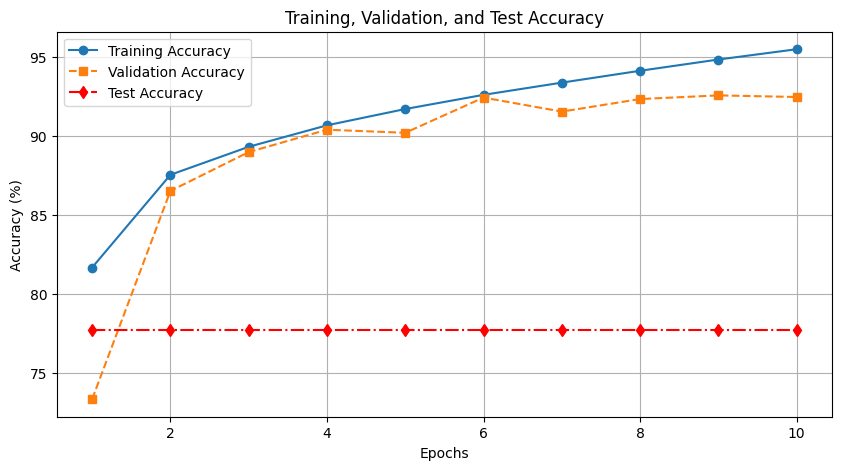

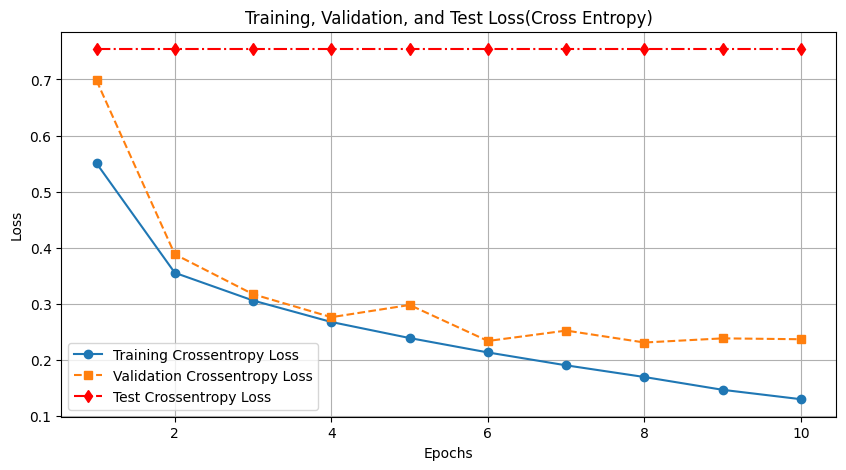

In [ ]:
import matplotlib.pyplot as plt

# Extract data from training_result dictionary
epochs = list(training_result.keys())
print(epochs)
train_acc = [training_result[epoch]['train_acc'] for epoch in epochs]
val_acc = [training_result[epoch]['val_acc'] for epoch in epochs]
train_loss = [training_result[epoch]['train_loss'] for epoch in epochs]
val_loss = [training_result[epoch]['val_loss'] for epoch in epochs]

# Test accuracy and loss
test_epoch = epochs[-1] + 1  # Assuming test comes after training epochs
test_acc_list = [test_accuracy] * len(epochs)  # Repeat test accuracy for visualization
test_loss_list = [avg_test_loss] * len(epochs)  # Repeat test loss for visualization

# ---- Plot Accuracy ----
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o', linestyle='-')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='s', linestyle='--')
plt.plot(epochs, test_acc_list, label='Test Accuracy', marker='d', linestyle='-.', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# ---- Plot Loss ----
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Crossentropy Loss', marker='o', linestyle='-')
plt.plot(epochs, val_loss, label='Validation Crossentropy Loss', marker='s', linestyle='--')
plt.plot(epochs, test_loss_list, label='Test Crossentropy Loss', marker='d', linestyle='-.', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss(Cross Entropy)')
plt.legend()
plt.grid(True)
plt.show()


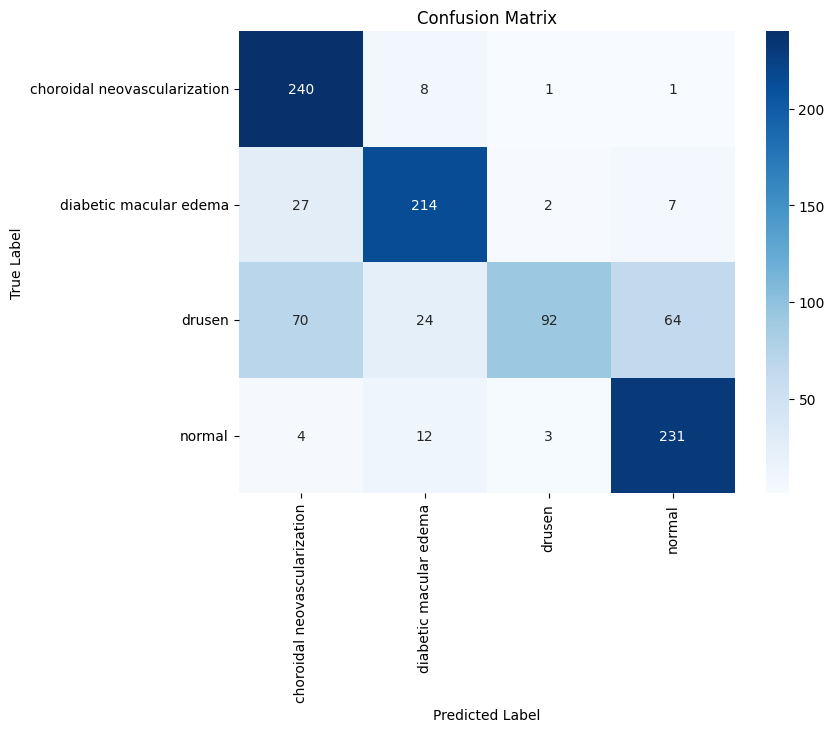

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions on test set
def get_predictions(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get the predicted class
            all_preds.extend(preds.cpu().numpy())  # Move to CPU
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# Compute predictions
preds, true_labels = get_predictions(model, test_loader, device)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


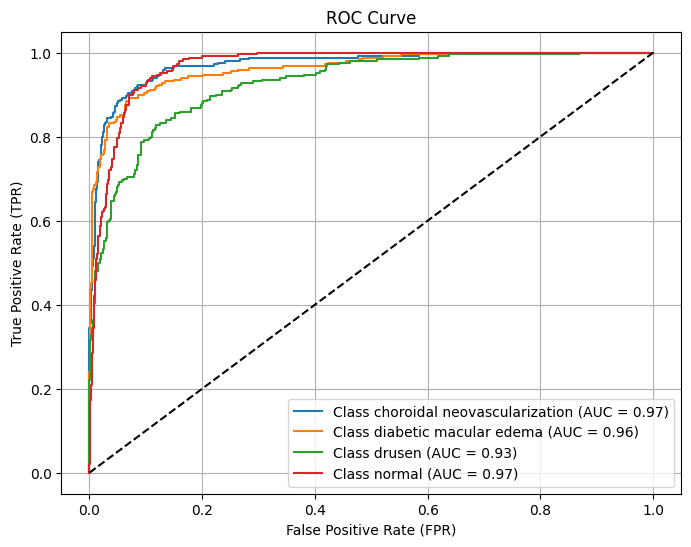

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert labels to one-hot encoding (for multi-class ROC)
true_labels_one_hot = label_binarize(true_labels, classes=list(range(n_classes)))

# Get model probabilities
def get_probabilities(model, test_loader, device):
    model.eval()
    all_probs = []

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = torch.softmax(model(images), dim=1)  # Get probabilities
            all_probs.extend(outputs.cpu().numpy())  # Move to CPU

    return np.array(all_probs)

# Get probabilities
probs = get_probabilities(model, test_loader, device)

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_labels[i]} (AUC = {roc_auc:.2f})')

# Final plot settings
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


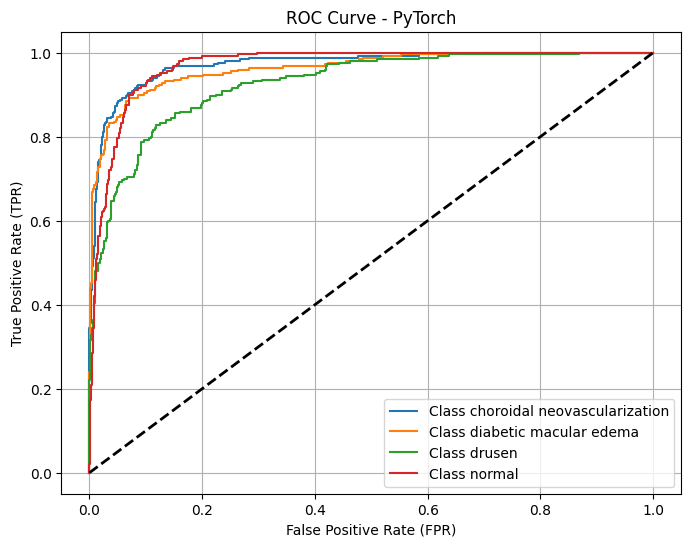

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassROC

# Ensure labels are tensor & 1D
true_labels_tensor = torch.tensor(true_labels).long().flatten()  # Convert to 1D tensor

# Ensure probabilities are correctly formatted (Apply softmax if needed)
probs_tensor = torch.tensor(probs)
if probs_tensor.ndim == 1:  # If only one probability per sample, reshape
    probs_tensor = probs_tensor.unsqueeze(1)

# Initialize ROC metric
roc = MulticlassROC(num_classes=n_classes)

# Compute ROC curve
fpr, tpr, thresholds = roc(probs_tensor, true_labels_tensor)

# Plot ROC Curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i].cpu(), tpr[i].cpu(), label=f'Class {class_labels[i]}')

# Add diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Label the plot
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - PyTorch")
plt.legend(loc="lower right")
plt.grid()

# Show the plot
plt.show()


### **Train with focal loss instead of cross entropy**

In [6]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')  # Use CE internally

    def forward(self, outputs, labels):
        ce_loss = self.ce(outputs, labels)  # Compute standard CE loss
        pt = torch.exp(-ce_loss)  # Probability of the correct class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss  # Apply focusing term
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

# Initialize Focal Loss instead of CrossEntropyLoss
criterion = FocalLoss(gamma=2.0, alpha=0.25)

model = DeeperSeqCNN(num_classes=4).to(device)
model.apply(initialize_weights_kaiming)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0006, weight_decay=5e-4)
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
DeeperSeqCNN                             [1, 4]                    --
├─Sequential: 1-1                        [1, 4]                    --
│    └─Conv2d: 2-1                       [1, 64, 28, 28]           640
│    └─BatchNorm2d: 2-2                  [1, 64, 28, 28]           128
│    └─LeakyReLU: 2-3                    [1, 64, 28, 28]           --
│    └─MaxPool2d: 2-4                    [1, 64, 14, 14]           --
│    └─Conv2d: 2-5                       [1, 128, 14, 14]          73,856
│    └─BatchNorm2d: 2-6                  [1, 128, 14, 14]          256
│    └─LeakyReLU: 2-7                    [1, 128, 14, 14]          --
│    └─MaxPool2d: 2-8                    [1, 128, 7, 7]            --
│    └─Conv2d: 2-9                       [1, 256, 7, 7]            295,168
│    └─BatchNorm2d: 2-10                 [1, 256, 7, 7]            512
│    └─LeakyReLU: 2-11                   [1, 256, 7, 7]            --
│ 

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score

# Initialize metric trackers
num_classes = 4  # Adjust based on the number of classes in your dataset
train_acc_metric_focal = Accuracy(task="multiclass", num_classes=num_classes).to(device)
val_acc_metric_focal = Accuracy(task="multiclass", num_classes=num_classes).to(device)
precision_metric_focal = Precision(task="multiclass", num_classes=num_classes, average="macro").to(device)
recall_metric_focal = Recall(task="multiclass", num_classes=num_classes, average="macro").to(device)
f1_metric_focal = F1Score(task="multiclass", num_classes=num_classes, average="macro").to(device)

NUM_EPOCHS = 10
best_val_acc_focal = 0.0  # Track the best validation accuracy
best_model_path_focal = "first_neural_network_best_weights_focal.pt"
training_result_focal = {}

for epoch in range(NUM_EPOCHS):
    # Training Phase
    model.train()
    running_loss_focal = 0.0
    train_acc_metric_focal.reset()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.squeeze(dim=1)  # Ensure correct shape

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss_focal = criterion(outputs, labels)

        # Backpropagation
        loss_focal.backward()

        # Gradient clipping (optional)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights
        optimizer.step()

        # Update training metrics
        running_loss_focal += loss_focal.item()
        preds_focal = torch.argmax(outputs, dim=1)
        train_acc_metric_focal.update(preds_focal, labels)

    avg_train_loss_focal = running_loss_focal / len(train_loader)
    train_accuracy_focal = train_acc_metric_focal.compute().item() * 100  # Convert to percentage

    # Validation Phase
    model.eval()
    running_val_loss_focal = 0.0
    val_acc_metric_focal.reset()
    precision_metric_focal.reset()
    recall_metric_focal.reset()
    f1_metric_focal.reset()

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.squeeze(dim=1)

            # Forward pass
            outputs = model(images)
            loss_focal = criterion(outputs, labels)
            running_val_loss_focal += loss_focal.item()

            preds_focal = torch.argmax(outputs, dim=1)

            # Update validation metrics
            val_acc_metric_focal.update(preds_focal, labels)
            precision_metric_focal.update(preds_focal, labels)
            recall_metric_focal.update(preds_focal, labels)
            f1_metric_focal.update(preds_focal, labels)

    avg_val_loss_focal = running_val_loss_focal / len(val_loader)
    val_accuracy_focal = val_acc_metric_focal.compute().item() * 100
    precision_focal = precision_metric_focal.compute().item()
    recall_focal = recall_metric_focal.compute().item()
    f1_score_focal = f1_metric_focal.compute().item()


    # Store results
    training_result_focal[epoch+1] = {
        'train_loss_focal': avg_train_loss_focal,
        'train_acc_focal': train_accuracy_focal,
        'val_loss_focal': avg_val_loss_focal,
        'val_acc_focal': val_accuracy_focal,
        'precision_focal': precision_focal,
        'recall_focal': recall_focal,
        'f1_score_focal': f1_score_focal
    }

    # Print training progress
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], "
          f"Train Loss: {avg_train_loss_focal:.4f}, Train Accuracy: {train_accuracy_focal:.2f}%, "
          f"Val Loss: {avg_val_loss_focal:.4f}, Val Accuracy: {val_accuracy_focal:.2f}%, "
          f"Precision: {precision_focal:.4f}, Recall: {recall_focal:.4f}, F1 Score: {f1_score_focal:.4f}")

    # Save the model if it has the best validation accuracy
    if val_accuracy_focal > best_val_acc_focal:
        best_val_acc_focal = val_accuracy_focal  # Update best accuracy
        torch.save(model.state_dict(), best_model_path_focal)
        print(f" New best model saved at epoch {epoch+1} with Validation Accuracy: {val_accuracy_focal:.2f}%")

print("Training Complete! Best Validation Accuracy:", best_val_acc_focal)


Epoch [1/10], Train Loss: 0.5409, Train Accuracy: 81.97%, Val Loss: 0.3676, Val Accuracy: 87.51%, Precision: 0.8151, Recall: 0.7151, F1 Score: 0.7459
 New best model saved at epoch 1 with Validation Accuracy: 87.51%
Epoch [2/10], Train Loss: 0.3484, Train Accuracy: 87.88%, Val Loss: 0.3329, Val Accuracy: 88.62%, Precision: 0.8234, Recall: 0.7628, F1 Score: 0.7782
 New best model saved at epoch 2 with Validation Accuracy: 88.62%
Epoch [3/10], Train Loss: 0.2975, Train Accuracy: 89.58%, Val Loss: 0.3241, Val Accuracy: 89.02%, Precision: 0.8554, Recall: 0.7426, F1 Score: 0.7800
 New best model saved at epoch 3 with Validation Accuracy: 89.02%
Epoch [4/10], Train Loss: 0.2609, Train Accuracy: 90.94%, Val Loss: 0.2673, Val Accuracy: 90.74%, Precision: 0.8567, Recall: 0.8120, F1 Score: 0.8318
 New best model saved at epoch 4 with Validation Accuracy: 90.74%
Epoch [5/10], Train Loss: 0.2334, Train Accuracy: 91.85%, Val Loss: 0.2548, Val Accuracy: 91.24%, Precision: 0.8638, Recall: 0.8293, F1 

In [9]:
# Set model to evaluation mode

best_model_path = "first_neural_network_best_weights_focal.pt"
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

# Initialize counters
correct_test = 0
total_test = 0
running_test_loss = 0.0

# Disable gradient computation for efficiency
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Convert labels if necessary
        if len(labels.shape) == 2 and labels.shape[1] == 1:
            labels = labels.squeeze(dim=1)  # Convert [batch_size, 1] → [batch_size]
        elif len(labels.shape) == 2 and labels.shape[1] > 1:
            labels = labels.argmax(dim=1)  # Convert one-hot → class indices

        # Forward pass (get predictions)
        outputs = model(images)
        loss = criterion(outputs, labels)  # Compute loss

        running_test_loss += loss.item()

        # Get predicted classes
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

# Compute final test accuracy & loss
test_accuracy = 100 * correct_test / total_test
avg_test_loss = running_test_loss / len(test_loader)

# Print final results
print(f" Test Accuracy: {test_accuracy:.2f}%")
print(f" Test Loss: {avg_test_loss:.4f}")

<ipython-input-9-6342c92f0dd1>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


 Test Accuracy: 70.50%
 Test Loss: 1.1429


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


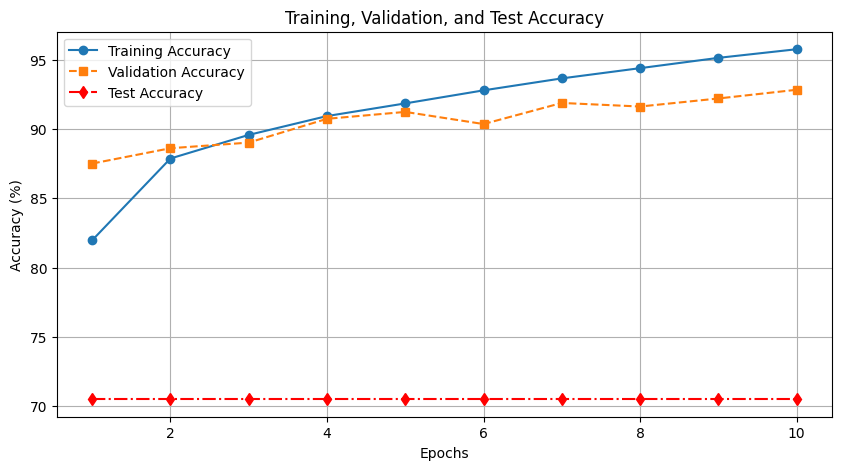

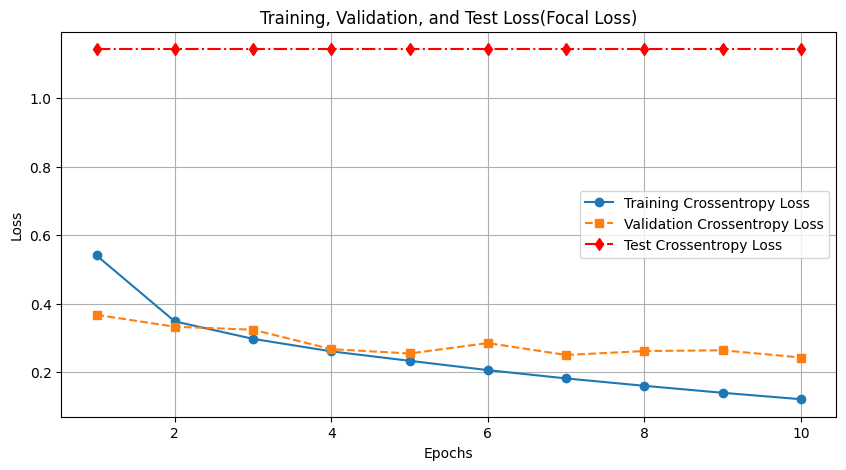

In [11]:
import matplotlib.pyplot as plt

# Extract data from training_result dictionary
epochs = list(training_result_focal.keys())
print(epochs)
train_acc = [training_result_focal[epoch]['train_acc_focal'] for epoch in epochs]
val_acc = [training_result_focal[epoch]['val_acc_focal'] for epoch in epochs]
train_loss = [training_result_focal[epoch]['train_loss_focal'] for epoch in epochs]
val_loss = [training_result_focal[epoch]['val_loss_focal'] for epoch in epochs]

# Test accuracy and loss
test_epoch = epochs[-1] + 1  # Assuming test comes after training epochs
test_acc_list = [test_accuracy] * len(epochs)  # Repeat test accuracy for visualization
test_loss_list = [avg_test_loss] * len(epochs)  # Repeat test loss for visualization

# ---- Plot Accuracy ----
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o', linestyle='-')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='s', linestyle='--')
plt.plot(epochs, test_acc_list, label='Test Accuracy', marker='d', linestyle='-.', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# ---- Plot Loss ----
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Crossentropy Loss', marker='o', linestyle='-')
plt.plot(epochs, val_loss, label='Validation Crossentropy Loss', marker='s', linestyle='--')
plt.plot(epochs, test_loss_list, label='Test Crossentropy Loss', marker='d', linestyle='-.', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss(Focal Loss)')
plt.legend()
plt.grid(True)
plt.show()


Improved Neural network

In [ ]:
data_transform = transforms.Compose([

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

data_transform_training = transforms.Compose([
  #  transforms.RandomRotation(15),  # Rotate images randomly by ±15°
    transforms.RandomHorizontalFlip(),  # Flip images horizontally
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Random translations
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),  # Random crop & resize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
# load the data
train_dataset = DataClass(split='train', transform=data_transform_training, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz


In [ ]:
model = DeeperSeqCNN(num_classes=4).to(device)
# Apply to model
model.apply(initialize_weights_kaiming)
summary(model, input_size=(1, 1, 28, 28))
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.0006, momentum=0.9, weight_decay=5e-4)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


In [ ]:
NUM_EPOCHS = 10
best_val_acc_new = 0.0  # Track the best validation accuracy
best_model_path = "improved_neural_network_best_weights.pt"
training_result_new = {}
num_classes = 4  # Adjust based on your number of classes
train_acc_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)
val_acc_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)
precision_metric = Precision(task="multiclass", num_classes=num_classes, average="macro").to(device)
recall_metric = Recall(task="multiclass", num_classes=num_classes, average="macro").to(device)
f1_metric = F1Score(task="multiclass", num_classes=num_classes, average="macro").to(device)

for epoch in range(NUM_EPOCHS):
    # Training Phase
    model.train()
    running_loss = 0.0
    train_acc_metric.reset()
    epoch_start_time = time.time()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.squeeze(dim=1)  # Ensure correct shape

        # Reset gradients
       # optimizer.zero_grad()
        for param in model.parameters():
          param.grad = None

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backpropagation
        loss.backward()

        # Gradient clipping (optional)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights
        optimizer.step()

        # Training metrics
        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_acc_metric.update(preds, labels)

    avg_train_loss_new = running_loss / len(train_loader)
    train_accuracy_new = train_acc_metric.compute().item() * 100  # Convert to percentage

    # Validation Phase
    model.eval()
    running_val_loss = 0.0
    val_acc_metric.reset()
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.squeeze(dim=1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            val_acc_metric.update(preds, labels)
            precision_metric.update(preds, labels)
            recall_metric.update(preds, labels)
            f1_metric.update(preds, labels)

    avg_val_loss_new = running_val_loss / len(val_loader)
    val_accuracy_new = val_acc_metric.compute().item() * 100
    precision = precision_metric.compute().item()
    recall = recall_metric.compute().item()
    f1_score = f1_metric.compute().item()

    scheduler.step(avg_val_loss_new)
    epoch_time=time.time() - epoch_start_time
    # Store results
    training_result_new[epoch+1] = {
        'train_loss': avg_train_loss_new,
        'train_acc': train_accuracy_new,
        'val_loss': avg_val_loss_new,
        'val_acc': val_accuracy_new,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'epoch_time_sec': epoch_time
    }

    # Print training progress
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], "
          f"Train Loss: {avg_train_loss_new:.4f}, Train Accuracy: {train_accuracy_new:.2f}%, "
          f"Val Loss: {avg_val_loss_new:.4f}, Val Accuracy: {val_accuracy_new:.2f}%, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}, "
          f"Time: {epoch_time:.2f} sec")

    # Save the model if it has the best validation accuracy
    if val_accuracy_new > best_val_acc_new:
        best_val_acc_new = val_accuracy_new  # Update best accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f" New best model saved at epoch {epoch+1} with Validation Accuracy: {val_accuracy_new:.2f}%")

print("Training Complete! Best Validation Accuracy:", best_val_acc_new)

Epoch [1/10], Train Loss: 0.7038, Train Accuracy: 76.73%, Val Loss: 0.5222, Val Accuracy: 82.14%, Precision: 0.7247, Recall: 0.6028, F1 Score: 0.6088, Time: 65.25 sec
 New best model saved at epoch 1 with Validation Accuracy: 82.14%
Epoch [2/10], Train Loss: 0.5008, Train Accuracy: 82.66%, Val Loss: 0.4630, Val Accuracy: 84.17%, Precision: 0.7888, Recall: 0.6282, F1 Score: 0.6426, Time: 83.82 sec
 New best model saved at epoch 2 with Validation Accuracy: 84.17%
Epoch [3/10], Train Loss: 0.4640, Train Accuracy: 83.90%, Val Loss: 0.4277, Val Accuracy: 85.22%, Precision: 0.7829, Recall: 0.6676, F1 Score: 0.6944, Time: 69.68 sec
 New best model saved at epoch 3 with Validation Accuracy: 85.22%
Epoch [4/10], Train Loss: 0.4338, Train Accuracy: 84.99%, Val Loss: 0.3798, Val Accuracy: 86.92%, Precision: 0.8074, Recall: 0.6971, F1 Score: 0.7244, Time: 64.77 sec
 New best model saved at epoch 4 with Validation Accuracy: 86.92%
Epoch [5/10], Train Loss: 0.4150, Train Accuracy: 85.45%, Val Loss: 

In [ ]:

# Initialize metric trackers
num_classes = 4  # Adjust based on your dataset
test_acc_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)
precision_metric = Precision(task="multiclass", num_classes=num_classes, average="macro").to(device)
recall_metric = Recall(task="multiclass", num_classes=num_classes, average="macro").to(device)
f1_metric = F1Score(task="multiclass", num_classes=num_classes, average="macro").to(device)

# Set model to evaluation mode
best_model_path = "improved_neural_network_best_weights.pt"
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

# Initialize loss tracker
running_test_loss = 0.0

# Reset metrics
test_acc_metric.reset()
precision_metric.reset()
recall_metric.reset()
f1_metric.reset()

# Disable gradient computation for efficiency
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Convert labels if necessary
        if len(labels.shape) == 2 and labels.shape[1] == 1:
            labels = labels.squeeze(dim=1)  # Convert [batch_size, 1] → [batch_size]
        elif len(labels.shape) == 2 and labels.shape[1] > 1:
            labels = labels.argmax(dim=1)  # Convert one-hot → class indices

        # Forward pass (get predictions)
        outputs = model(images)
        loss = criterion(outputs, labels)  # Compute loss

        running_test_loss += loss.item()

        # Get predicted classes
        preds = torch.argmax(outputs, dim=1)

        # Update metrics
        test_acc_metric.update(preds, labels)
        precision_metric.update(preds, labels)
        recall_metric.update(preds, labels)
        f1_metric.update(preds, labels)

# Compute final test accuracy, precision, recall, and F1-score
test_accuracy_new = test_acc_metric.compute().item() * 100  # Convert to percentage
precision = precision_metric.compute().item()
recall = recall_metric.compute().item()
f1_score = f1_metric.compute().item()
avg_test_loss_new = running_test_loss / len(test_loader)

# Print final results
print(f" Test Accuracy: {test_accuracy_new:.2f}%")
print(f" Test Loss: {avg_test_loss_new:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1 Score: {f1_score:.4f}")


<ipython-input-132-bb3ede6604e2>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


 Test Accuracy: 78.20%
 Test Loss: 0.5863
 Precision: 0.8175
 Recall: 0.7820
 F1 Score: 0.7606


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


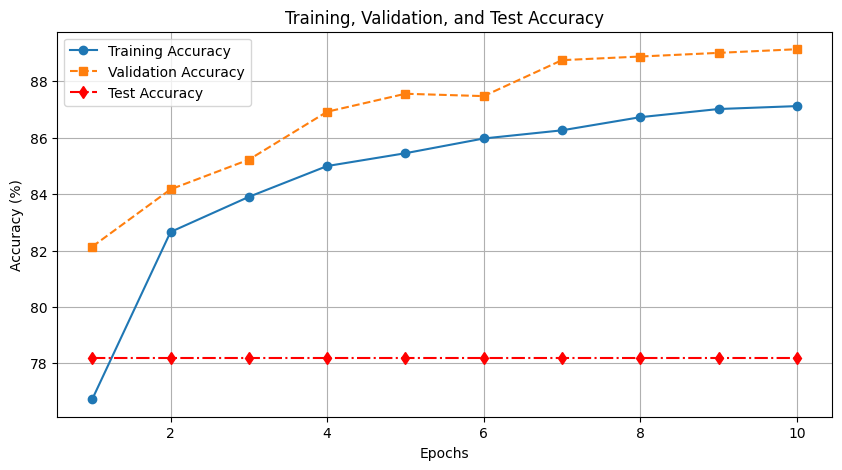

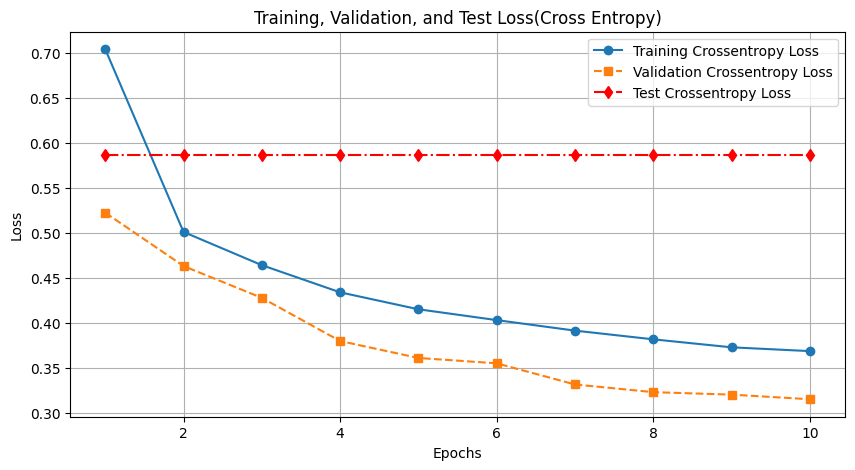

In [ ]:
import matplotlib.pyplot as plt

# Extract data from training_result dictionary
epochs = list(training_result_new.keys())
print(epochs)
train_acc = [training_result_new[epoch]['train_acc'] for epoch in epochs]
val_acc = [training_result_new[epoch]['val_acc'] for epoch in epochs]
train_loss = [training_result_new[epoch]['train_loss'] for epoch in epochs]
val_loss = [training_result_new[epoch]['val_loss'] for epoch in epochs]

# Test accuracy and loss
test_epoch = epochs[-1] + 1  # Assuming test comes after training epochs
test_acc_list = [test_accuracy_new] * len(epochs)  # Repeat test accuracy for visualization
test_loss_list = [avg_test_loss_new] * len(epochs)  # Repeat test loss for visualization

# ---- Plot Accuracy ----
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o', linestyle='-')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='s', linestyle='--')
plt.plot(epochs, test_acc_list, label='Test Accuracy', marker='d', linestyle='-.', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# ---- Plot Loss ----
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Crossentropy Loss', marker='o', linestyle='-')
plt.plot(epochs, val_loss, label='Validation Crossentropy Loss', marker='s', linestyle='--')
plt.plot(epochs, test_loss_list, label='Test Crossentropy Loss', marker='d', linestyle='-.', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss(Cross Entropy)')
plt.legend()
plt.grid(True)
plt.show()


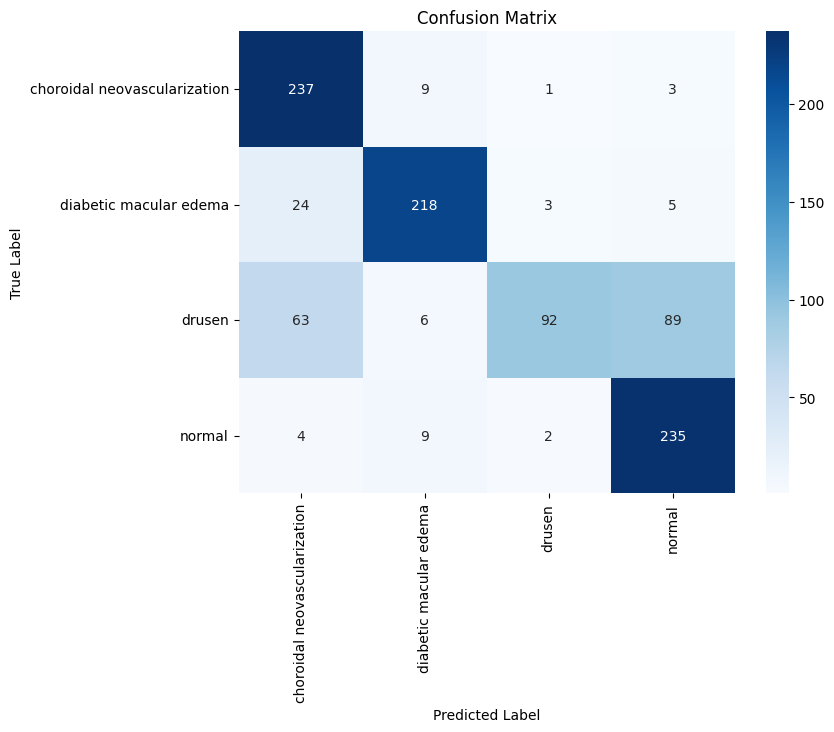

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions on test set
def get_predictions(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get the predicted class
            all_preds.extend(preds.cpu().numpy())  # Move to CPU
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# Compute predictions
preds, true_labels = get_predictions(model, test_loader, device)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


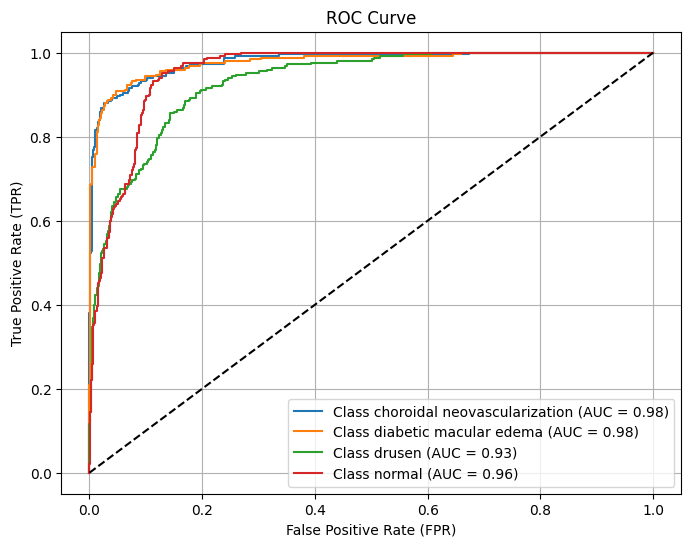

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert labels to one-hot encoding (for multi-class ROC)
true_labels_one_hot = label_binarize(true_labels, classes=list(range(n_classes)))

# Get model probabilities
def get_probabilities(model, test_loader, device):
    model.eval()
    all_probs = []

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = torch.softmax(model(images), dim=1)  # Get probabilities
            all_probs.extend(outputs.cpu().numpy())  # Move to CPU

    return np.array(all_probs)

# Get probabilities
probs = get_probabilities(model, test_loader, device)

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_labels[i]} (AUC = {roc_auc:.2f})')

# Final plot settings
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


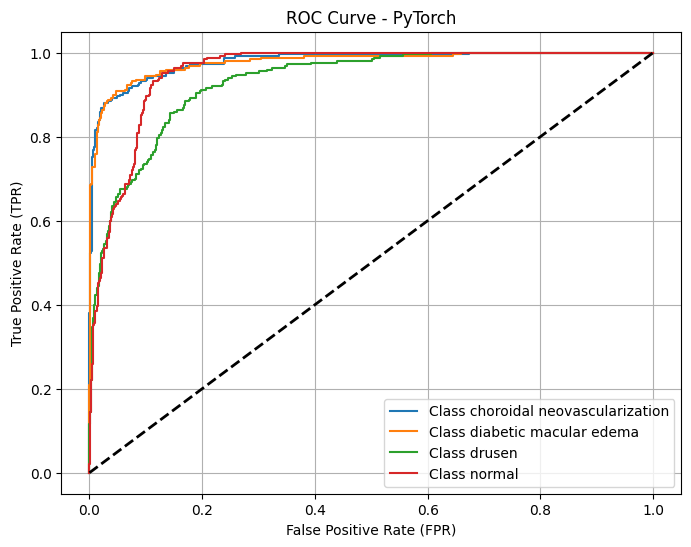

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassROC

# Ensure labels are tensor & 1D
true_labels_tensor = torch.tensor(true_labels).long().flatten()  # Convert to 1D tensor

# Ensure probabilities are correctly formatted (Apply softmax if needed)
probs_tensor = torch.tensor(probs)
if probs_tensor.ndim == 1:  # If only one probability per sample, reshape
    probs_tensor = probs_tensor.unsqueeze(1)

# Initialize ROC metric
roc = MulticlassROC(num_classes=n_classes)

# Compute ROC curve
fpr, tpr, thresholds = roc(probs_tensor, true_labels_tensor)

# Plot ROC Curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i].cpu(), tpr[i].cpu(), label=f'Class {class_labels[i]}')

# Add diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Label the plot
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - PyTorch")
plt.legend(loc="lower right")
plt.grid()

# Show the plot
plt.show()


### **Data Visualisation(Training Data)**

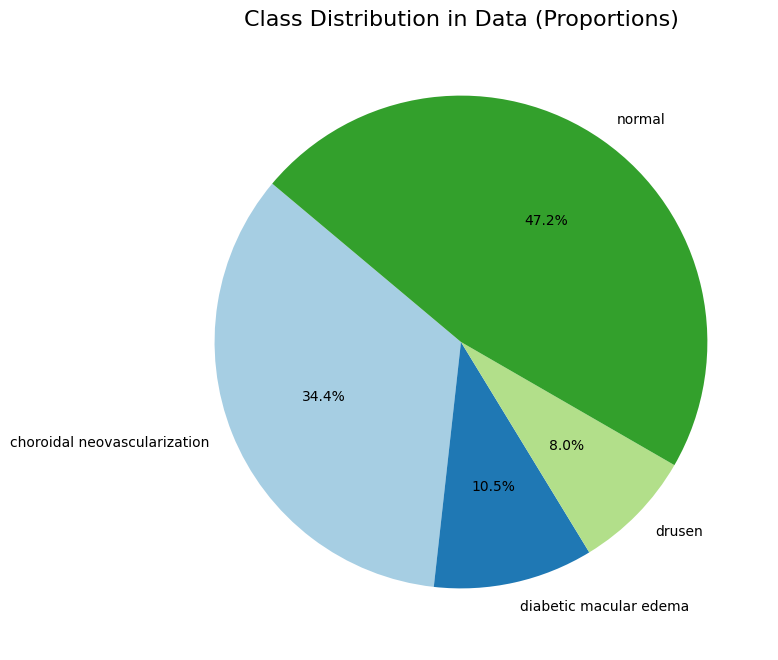

In [ ]:
from torch.utils.data import ConcatDataset
# Extract labels for the training dataset
full_dataset = ConcatDataset([train_dataset, test_dataset, val_dataset])
train_labels = [full_dataset[i][1] for i in range(len(train_dataset))]

# Get unique classes and counts
unique_classes, class_counts = np.unique(train_labels, return_counts=True)

# Map class indices to human-readable labels
class_labels = {int(k): v for k, v in INFO['octmnist']['label'].items()}
class_names = [class_labels[i] for i in unique_classes]
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Class Distribution in Data (Proportions)", fontsize=16)
plt.show()

<ipython-input-138-c46443f5dc1f>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels = [int(full_dataset[i][1]) for i in range(len(full_dataset))]  # Ensure labels are integers


Class Distribution: Counter({3: 51390, 0: 37455, 1: 11598, 2: 8866})


<ipython-input-138-c46443f5dc1f>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  images = [full_dataset[i][0].detach().cpu().numpy() for i in range(len(full_dataset)) if int(full_dataset[i][1]) == class_label]


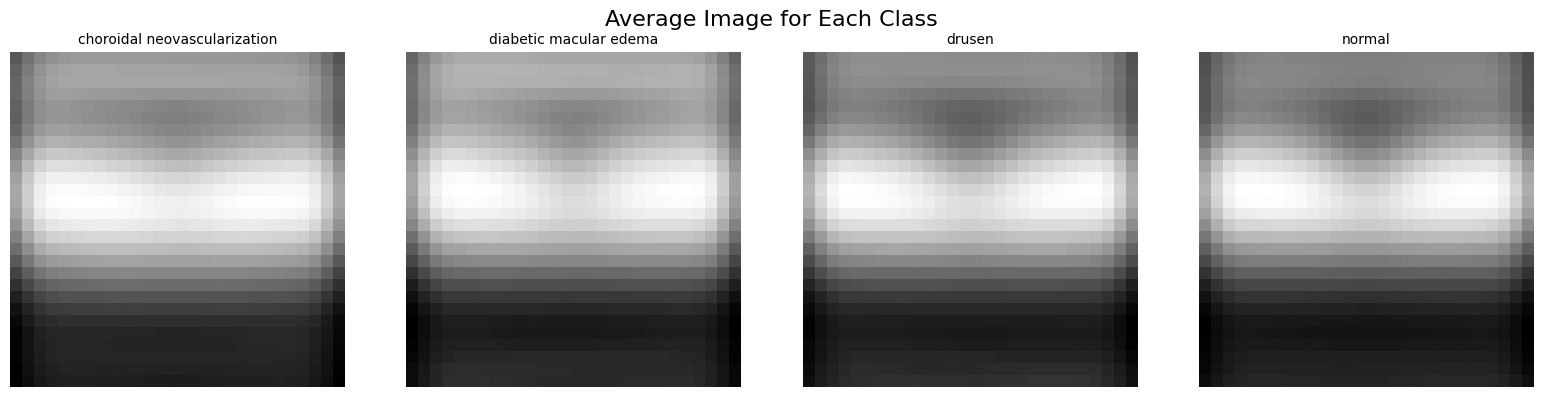

In [ ]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

average_images = {}

# Get class label distribution for debugging
labels = [int(full_dataset[i][1]) for i in range(len(full_dataset))]  # Ensure labels are integers
print("Class Distribution:", Counter(labels))  # Debugging Step

for class_label in unique_classes:
    # Collect all images for this class
    images = [full_dataset[i][0].detach().cpu().numpy() for i in range(len(full_dataset)) if int(full_dataset[i][1]) == class_label]

    if len(images) > 0:  # Ensure there are images for this class
        avg_image = np.mean(images, axis=0)
    else:
        avg_image = np.zeros_like(full_dataset[0][0])  # Fallback in case of missing data

    average_images[class_label] = avg_image

# Plot the average images
fig, axes = plt.subplots(1, len(unique_classes), figsize=(16, 4))

for i, (class_label, avg_image) in enumerate(average_images.items()):
    axes[i].imshow(avg_image.squeeze(), cmap='gray')
    axes[i].set_title(f"{class_labels[class_label]}", fontsize=10)
    axes[i].axis('off')

plt.suptitle("Average Image for Each Class", fontsize=16)
plt.tight_layout()
plt.show()


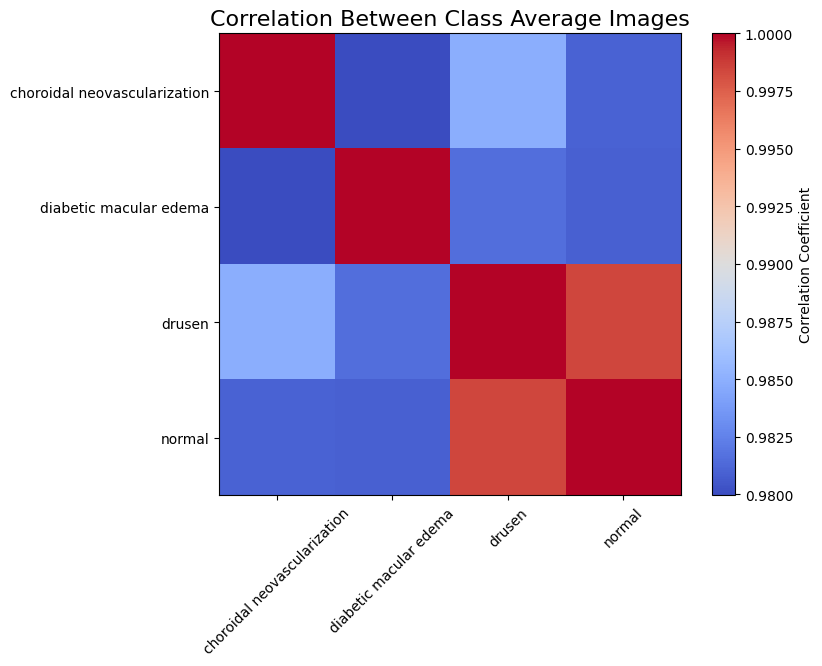

In [ ]:
avg_images_flat = [average_images[class_label].flatten() for class_label in unique_classes]
correlation_matrix = np.corrcoef(avg_images_flat)

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label="Correlation Coefficient")
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)
plt.title("Correlation Between Class Average Images", fontsize=16)
plt.show()

In [14]:
import torch

# Load the .pt file
checkpoint = torch.load("improved_neural_network_best_weights.pt", map_location=torch.device('cpu'))

# Check if it's a state_dict or full model
if isinstance(checkpoint, dict):  # If it's a state dictionary
    print("\n✅ Model State Dictionary Keys (Layers with Weights & Biases):")
    for key, value in checkpoint.items():
        print(f"{key}: {value.shape}")  # Show layer names and tensor shapes

    # Print weights and biases explicitly
    print("\n🔎 Weights and Biases Details:\n")
    for key, value in checkpoint.items():
        print(f"🔹 {key}:\n{value}\n")

elif hasattr(checkpoint, 'state_dict'):  # If it's a full model
    model = checkpoint
    print("\n✅ Model Architecture:\n", model)

    print("\n✅ Model Weights and Biases:")
    for name, param in model.state_dict().items():
        print(f"🔹 {name}: {param.shape}\n{param}\n")
else:
    print("❌ The .pt file format is not recognized. Ensure it's a valid PyTorch model checkpoint.")



✅ Model State Dictionary Keys (Layers with Weights & Biases):
model.0.weight: torch.Size([64, 1, 3, 3])
model.0.bias: torch.Size([64])
model.1.weight: torch.Size([64])
model.1.bias: torch.Size([64])
model.1.running_mean: torch.Size([64])
model.1.running_var: torch.Size([64])
model.1.num_batches_tracked: torch.Size([])
model.4.weight: torch.Size([128, 64, 3, 3])
model.4.bias: torch.Size([128])
model.5.weight: torch.Size([128])
model.5.bias: torch.Size([128])
model.5.running_mean: torch.Size([128])
model.5.running_var: torch.Size([128])
model.5.num_batches_tracked: torch.Size([])
model.8.weight: torch.Size([256, 128, 3, 3])
model.8.bias: torch.Size([256])
model.9.weight: torch.Size([256])
model.9.bias: torch.Size([256])
model.9.running_mean: torch.Size([256])
model.9.running_var: torch.Size([256])
model.9.num_batches_tracked: torch.Size([])
model.12.weight: torch.Size([512, 256, 3, 3])
model.12.bias: torch.Size([512])
model.13.weight: torch.Size([512])
model.13.bias: torch.Size([512])
m

<ipython-input-14-1f441244b00a>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("improved_neural_network_best_weights_78.pt", map_location=torch.dev